In [72]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler 

from matplotlib import pyplot as plot

#biblioteca para fazer fazer a regressão
from sklearn.tree import DecisionTreeRegressor

#biblioteca para calcular uma métrica de avaliação
from sklearn.metrics import mean_squared_error

In [26]:
df = pd.read_excel('https://github.com/andrevandor/ProjetoIntegrador/raw/master/data/HDI_1990_2018.xlsx')

## Treatment of Null Values

In [27]:
df.head()

,Paises,Ano,Expectativa de vida no nascimento,Anos esperados de escolaridade,Média de anos de escolaridade,Renda nacional bruta (RNB) per capita (PPP US$),IDH,CPI (Corruption Index)
0,Norway,1990,76.729,14.0,10.47,17910.0,0.85,NaN
1,Switzerland,1990,77.568,13.4,10.19,28170.0,0.83,NaN
2,Ireland,1990,74.809,12.1,9.73,12750.0,0.76,NaN
3,Germany,1990,75.488,14.4,8.77,19640.0,0.80,NaN
4,China,1990,69.145,8.8,5.34,17760.0,0.50,NaN


In [28]:
def EDA (df):
    eda_df = {}
    eda_df['Qtde_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Qtde_Unicos'] = df.count()
    
    colunas = sorted(df.columns.tolist(), key=str.lower, reverse=False)
    eda_df['Qtde_Unicos'] = filtered_result = list(map(lambda x: len(df[x].unique().tolist()), colunas))
    
    eda_df['Media'] = df.mean().round(3)
    eda_df['Min'] = df.min()
    eda_df['Max'] = df.max()
    eda_df['STD'] = df.std().round(3)
    
    return pd.DataFrame(eda_df)

In [29]:
EDA(df.drop(['Ano','Paises'], axis = 1))

,Qtde_NaN,%_NaN,DType,Qtde_Unicos,Media,Min,Max,STD
Expectativa de vida no nascimento,84,0.02,float64,370,68.275,26.172,84.47000,9.565
Anos esperados de escolaridade,279,0.05,float64,1,11.798,2.100,23.30000,3.361
Média de anos de escolaridade,551,0.10,float64,4909,7.483,0.290,14.13215,3.176
Renda nacional bruta (RNB) per capita (PPP US$),446,0.08,float64,77,13357.760,270.000,131510.00000,16401.756
IDH,1001,0.18,float64,429,0.657,0.200,0.95000,0.166
CPI (Corruption Index),5423,1.00,float64,2499,NaN,NaN,NaN,NaN


In [30]:
df_1 = df.copy()
df_1.drop(['IDH','CPI (Corruption Index)'], axis = 1, inplace = True)

df_1['Expectativa de vida no nascimento'].fillna(df_1['Expectativa de vida no nascimento'].mean(), inplace = True)
df_1['Anos esperados de escolaridade'].fillna(df_1['Anos esperados de escolaridade'].mean(), inplace = True)
df_1['Média de anos de escolaridade'].fillna(df_1['Média de anos de escolaridade'].mean(), inplace = True)
df_1['Renda nacional bruta (RNB) per capita (PPP US$)'].\
    fillna(df_1['Renda nacional bruta (RNB) per capita (PPP US$)'].mode()[0], inplace = True)

EDA(df_1.drop(['Ano','Paises'], axis = 1))

,Qtde_NaN,%_NaN,DType,Qtde_Unicos,Media,Min,Max,STD
Expectativa de vida no nascimento,0,0.0,float64,370,68.275,26.172,84.47000,9.491
Anos esperados de escolaridade,0,0.0,float64,4909,11.798,2.100,23.30000,3.273
Média de anos de escolaridade,0,0.0,float64,429,7.483,0.290,14.13215,3.011
Renda nacional bruta (RNB) per capita (PPP US$),0,0.0,float64,2498,12364.457,270.000,131510.00000,16059.301


## Feature Engineering

In [31]:
paises = df_1.Paises.unique()

In [32]:
index_paises = []
for i in range(len(paises)):
    index_paises.append (df_1[df_1.Paises == paises[i]].index)

In [33]:
df_2 = pd.DataFrame()
for i in range(len(index_paises)):
    df_2 = pd.concat([df_2, df_1.iloc[index_paises[i]]], axis = 0)

In [34]:
df_2.reset_index(inplace=True)
df_2.drop('index', axis=1, inplace=True)

In [35]:
index_paises = []

for i in range(len(paises)):
    index_paises.append (df_2[df_2.Paises == paises[i]].index)

In [51]:
def feature_engineering (df, horizonte, paises, index_paises, drop):
    
    data = df.copy()
    
    horizonte += 1

    for i in range(len(paises)):
        #
        data.loc[index_paises[i],'Diff_1'] = data.iloc[index_paises[i]]['Expectativa de vida no nascimento']\
                                            .diff(horizonte - 1)
        data.loc[index_paises[i],'Diff_2'] = data.iloc[index_paises[i]]['Anos esperados de escolaridade']\
                                            .diff(horizonte - 1)
        data.loc[index_paises[i],'Diff_3'] = data.iloc[index_paises[i]]['Média de anos de escolaridade']\
                                            .diff(horizonte - 1)
        data.loc[index_paises[i],'Diff_4'] = data.iloc[index_paises[i]]['Renda nacional bruta (RNB) per capita (PPP US$)']\
                                            .diff(horizonte - 1)
        #
        data.loc[index_paises[i], 'Med_1'] = data.iloc[index_paises[i]]['Expectativa de vida no nascimento']\
                                            .rolling(horizonte).mean().round(2)
        data.loc[index_paises[i], 'Med_2'] = data.iloc[index_paises[i]]['Anos esperados de escolaridade']\
                                            .rolling(horizonte).mean().round(2)
        data.loc[index_paises[i], 'Med_3'] = data.iloc[index_paises[i]]['Média de anos de escolaridade']\
                                            .rolling(horizonte).mean().round(2)
        data.loc[index_paises[i], 'Med_4'] = data.iloc[index_paises[i]]['Renda nacional bruta (RNB) per capita (PPP US$)']\
                                            .rolling(horizonte).mean().round(2)
        #
        data.loc[index_paises[i], 'Var_%_1'] = data.iloc[index_paises[i]]['Expectativa de vida no nascimento']\
                                            .pct_change(horizonte - 1).round(horizonte)
        data.loc[index_paises[i], 'Var_%_2'] = data.iloc[index_paises[i]]['Anos esperados de escolaridade']\
                                            .pct_change(horizonte - 1).round(horizonte)
        data.loc[index_paises[i], 'Var_%_3'] = data.iloc[index_paises[i]]['Média de anos de escolaridade']\
                                            .pct_change(horizonte - 1).round(horizonte)
        data.loc[index_paises[i], 'Var_%_4'] = data.iloc[index_paises[i]]['Renda nacional bruta (RNB) per capita (PPP US$)']\
                                            .pct_change(horizonte - 1).round(horizonte)
    
    if drop == True:
        data.dropna(how='any', axis=0, inplace=True)
    
    return data

### K-means and t-SNE

In [54]:
df_grouped = feature_engineering (df_2, horizonte, paises, index_paises, False)

In [55]:
lista_colunas = []
for x in df_grouped.columns:
    if df_grouped[x].dtype == float:
        lista_colunas.append(x)

In [56]:
df_grouped = pd.DataFrame(df_grouped.groupby(['Paises'])[lista_colunas].mean())

In [64]:
scaler = StandardScaler()  
df_grouped_norm = scaler.fit_transform(df_grouped)

1 2991.9999999999995
2 1921.1686608833204
3 1539.1349759232828
4 1310.921393163132
5 1123.4117047024881
6 1016.1432078704771
7 1006.3095559671939
8 855.1631699614255
9 810.9441669349525
10 756.3940115666696
11 724.0293334346719
12 701.1527373427249
13 674.283709289955
14 663.5175287678251
15 628.8170896426369
16 610.4911506325634
17 584.1524437791683
18 598.1661645407781
19 567.2500238713623
20 505.18839240846046


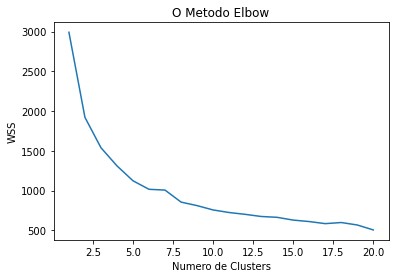

In [69]:
X = np.array(df_grouped_norm)
wcss = []
 
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X)
    print(i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)  
    
plt.plot(range(1, 21), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

In [70]:
n_clusters = 3
#Inicializando o KMeans
kmeans = KMeans(n_clusters)
#Fit nos dados
kmeans = kmeans.fit(X)
#predizendo os clusters
labels = kmeans.predict(X)
#Encontrando os centroides
C = kmeans.cluster_centers_

In [74]:
kmeans.cluster_centers_

array([[-1.22830434, -1.24742358, -1.22024478, -0.72564116,  0.94721393,
         0.35244761, -0.75934672, -0.66114092, -1.22586681, -1.24626668,
        -1.22061043, -0.72268596,  1.13535544,  0.8792668 ,  0.241438  ,
        -0.21379961],
       [ 0.22464017,  0.20030164,  0.2272919 , -0.26174737, -0.39213769,
        -0.32709496,  0.24514297, -0.19347394,  0.22380854,  0.19875075,
         0.22758887, -0.26143039, -0.35986762, -0.42012934, -0.06478098,
        -0.10088732],
       [ 1.05793415,  1.13537379,  1.0419552 ,  1.48904141, -0.3363255 ,
         0.27173841,  0.42124341,  1.25809694,  1.05667989,  1.13731107,
         1.04176612,  1.4846179 , -0.64442899, -0.18926764, -0.16277057,
         0.49078601]])

In [76]:
kmeans.labels_

array([0, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 1, 2, 1, 0, 0, 1, 1,
       1, 1, 2, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 2,
       2, 2, 0, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 2, 2, 1, 0, 1, 2, 0, 2,
       1, 0, 0, 0, 1, 0, 1, 2, 2, 0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 0, 1,
       1, 2, 1, 0, 1, 1, 1, 0, 1, 2, 2, 2, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 2, 2, 0, 1, 1, 1, 0,
       1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 0, 2, 0, 1, 1, 0, 2, 2, 2,
       0, 1, 0, 2, 1, 0, 1, 2, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 1])

In [73]:
X_reduzido = TSNE(n_components=2).fit_transform(X)
X_reduzido.shape

(187, 2)

In [77]:
n_clusters = 3
#Inicializando o KMeans
kmeans = KMeans(n_clusters)
#Fit nos dados
kmeans = kmeans.fit(X_reduzido)
#predizendo os clusters
labels = kmeans.predict(X_reduzido)
#Encontrando os centroides
C = kmeans.cluster_centers_

In [78]:
kmeans.cluster_centers_

array([[ 1.1185141 , -0.59166896],
       [ 9.36683   ,  8.125121  ],
       [-8.23125   , -3.8134317 ]], dtype=float32)

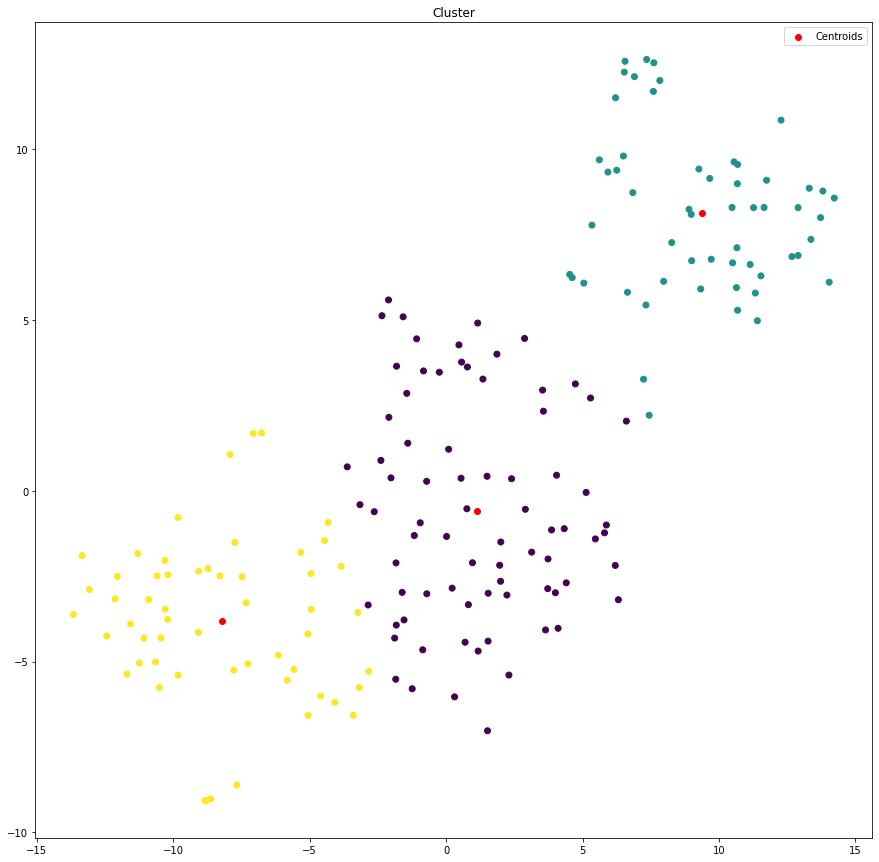

In [79]:
plt.figure(figsize=(15,15))

plt.scatter(X_reduzido[:, 0], X_reduzido[:, 1], s=plt.rcParams['lines.markersize']**2, c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],  c = 'red',label = 'Centroids')
plt.title('Cluster')
plt.legend()

plt.show()

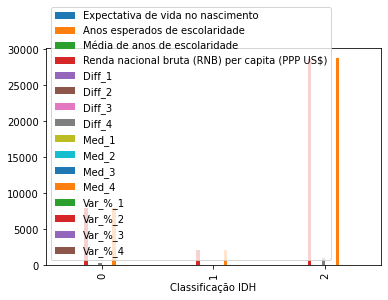

In [81]:
cluster_list = kmeans.labels_
df_grouped["Classificação IDH"] = cluster_list
df_grouped.groupby("Classificação IDH").aggregate("mean").plot.bar()

## Regression Tree

In [37]:
def split_prev(df, ano_ref, ano_prev, pais):
    
    data = df.copy()
    
    treino =  data.loc[(data.Ano <= ano_ref) & (data.Paises == pais)].copy()
    teste = data.loc[(data.Ano > ano_ref) & (data.Ano <= ano_prev) & (data.Paises == pais)].copy()
    
    #não iremos utilizar essa coluna para treinar nosso modelo
    treino.drop(['Ano', 'Paises'], axis=1, inplace=True)
    teste.drop(['Ano', 'Paises'], axis=1, inplace=True)

    #vamos dividir as variáveis alvo e de entrada
    y_treino = treino['Expectativa de vida no nascimento'].values
    del treino['Expectativa de vida no nascimento']
    
    x_treino = treino.values

    y_teste = teste['Expectativa de vida no nascimento'].values
    del teste['Expectativa de vida no nascimento']

    x_teste = teste.values;
    
    #treino do modelo para fazer a previsão
    regr_1 = DecisionTreeRegressor(max_depth=5, min_samples_split = 2, random_state = 2019)
    regr_1.fit(x_treino, y_treino)
    
    y_pred_teste = regr_1.predict(x_teste)
    y_pred_treino = regr_1.predict(x_treino)
    
    # Avaliar o fitting
    rmse_teste = np.round(mean_squared_error(y_teste, y_pred_teste) **0.5, 2)
    rmse_treino = np.round(mean_squared_error(y_treino, y_pred_treino)**0.5, 2)
    
    return ano_ref, ano_prev, pais, rmse_teste, rmse_treino

In [38]:
def walk_forward (data, janela, horizonte, passo, limite):
    result = []
    pais_ref = data.Paises.unique()
    controle = limite - janela
    
    ano_ref = janela
    
    while controle >= 0:
        ano_prev = ano_ref + horizonte
        
        if ano_prev > limite:
            break
            return result
                
        for i in paises:
            result.append(split_prev(data, ano_ref, ano_prev, i))

        ano_ref += passo
        controle -= passo
    return result

In [39]:
def analise_estabilidade(data, janela, limite):
    result = []
    controle = limite - janela
    
    ano_ref = janela
    ano_prev = janela
    
    while controle >= 0:
        ano_prev += 1
        
        if ano_prev > limite:
            break
            return result
        
        for i in paises:
            result.append(split_prev(data, ano_ref, ano_prev, i))

        controle -= 1
    
    return result

In [40]:
janela = 2005 #fará o walk de janela + horizonte, nesse caso pegará do menor ano até 2005 conjunto de treino.
horizonte = 1 #quantos anos para frente tentará prever
passo = 1 #no loop soma esse valor a janela.
limite = df_2.Ano.unique().max() #quando o loop para.

In [42]:
df_3 = feature_engineering (df_2, horizonte, paises, index_paises, True)

In [20]:
df_walk_forward = pd.DataFrame(data = walk_forward (df_3, janela, horizonte, passo, limite),\
                          columns=['Ano_Ref','Ano_Prev','Pais','Rmse_teste','Rmse_treino'])

In [21]:
df_walk_forward.head()

,Ano_Ref,Ano_Prev,Pais,Rmse_teste,Rmse_treino
0,2005,2006,Norway,0.50,0.0
1,2005,2006,Switzerland,0.51,0.0
2,2005,2006,Ireland,0.35,0.0
3,2005,2006,Germany,0.44,0.0
4,2005,2006,China,0.29,0.0


In [22]:
df_estabilidade = pd.DataFrame(data =  analise_estabilidade(df_3, janela, limite),\
                               columns=['Ano_Ref','Ano_Prev', 'Pais','Rmse_teste','Rmse_treino'])

In [85]:
df_estabilidade.head()

,Ano_Ref,Ano_Prev,Pais,Rmse_teste,Rmse_treino
0,2005,2006,Norway,0.50,0.0
1,2005,2006,Switzerland,0.51,0.0
2,2005,2006,Ireland,0.35,0.0
3,2005,2006,Germany,0.44,0.0
4,2005,2006,China,0.29,0.0
